In [1]:
clear all

In [2]:
import nibabel as nib
import os
import numpy as np
import scipy.io as sio
import scipy.optimize
from Tkinter import Tk
from tkFileDialog import askdirectory
import libtiff 
import matplotlib.pyplot as plt
%matplotlib inline

# Get video time

In [4]:
from pymatbridge import Matlab
mlab = Matlab()

/usr/local/lib/python2.7/dist-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


In [1]:
mlab = Matlab(executable='/usr/local/MATLAB/R2014b/bin/matlab')

NameError: name 'Matlab' is not defined

In [5]:
mlab.start()

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-7f160159-102e-46ad-9dcc-6803e92589da
Send 'exit' command to kill the server
.........MATLAB started and connected!


In [6]:
res = mlab.run_func('/home/sophie/git/FlyLFM/MatlabFiles/Behavior/avi2time.m', {'arg1': '/media/sophie2/945/combo_2015-06-19-215802-0000.avi'})
print(res['result'])

In [7]:
res

{u'content': {u'stdout': u"Reference to non-existent field 'cdata'."},
 u'result': u'',
 u'success': False}

In [7]:
exit()

MATLAB closed


In [ ]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

In [ ]:
Ua=sio.loadmat(filename)
DT=Ua['TSo']
DT.shape

# Get head video data

In [3]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
foldername = askdirectory() # show an "Open" dialog box and return the path to the selected file
print(foldername)

/media/sophie/100174ss2


In [4]:
path=foldername

In [5]:
A=foldername.split('/')
Dataname=A[-1]

In [6]:
Dataname

'100174ss2'

# Open the images

In [7]:
t = libtiff.TiffFile(path+'/'+Dataname+'-00001.tif') 
tt = t.get_tiff_array() 
t.close()
S=tt.shape
data=np.zeros([S[0],S[1],S[2],len(os.listdir(path))])
#for i in range(1,15000):
for i in range(len(os.listdir(path))):       
#for fn in os.listdir(path):
    t = libtiff.TiffFile(path+'/'+Dataname+'-'+str(i+1).zfill(5)+'.tif') 
    #t = libtiff.TiffFile(path+fn) 
    tt = t.get_tiff_array()
    data[:,:,:,i]=tt[:][:][:]
    t.close()
    i=i+1

In [8]:
S=data.shape
S

(40, 210, 210, 5056)

# Find end of onset of light and begining of offset (to align to behavior) 

Calculate average time series

In [9]:
M=np.mean(np.mean(np.mean(data,0),0),0)
Mav=M.mean()

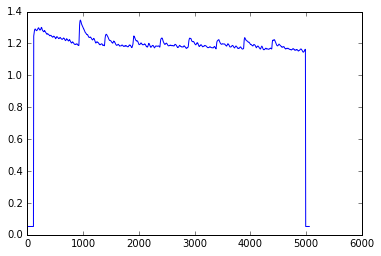

In [10]:
plt.plot(M)

Get approxiamte on and off times

In [11]:
liston=[i for i in range(len(M)) if M[i]>Mav*0.7]
liston[0]

114

Model for fitting onset and offset

In [12]:
def model(x,a,b,c,d):
    if x<a:
        return b
    elif x<c:
        return b+(x-a)*d
    else:
        return (c-a)*d+b

Model onset and find precise onset time

In [13]:
Ms=M[range(liston[0]-8,liston[0]+8)]

In [14]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))])   

In [15]:
liston[0]-8

106

In [16]:
res = scipy.optimize.minimize(Sq,x0=[7,0.3,9,0.7])

In [17]:
ON=liston[0]-8+res.x[2]
print(ON)

114.013555954


In [18]:
ONint=np.int(np.ceil(ON))
Onint=1
print(ONint)

115


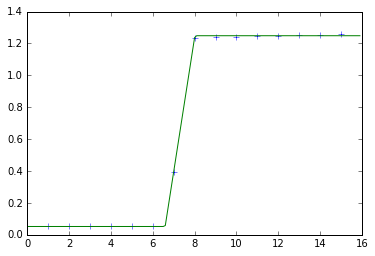

In [19]:
plt.plot(np.squeeze(M[range(liston[0]-8,liston[0]+8)]),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

Model offset and find precise offset time

In [20]:
Ms=M[range(liston[len(liston)-1]-6,liston[len(liston)-1]+6)]

In [21]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))]) 

In [22]:
res = scipy.optimize.minimize(Sq,x0=[7,3,9,-1])

In [23]:
OFF=liston[len(liston)-1]-8+res.x[0]
#OFF=liston[len(liston)-1]
print(OFF)
OFFint=np.int(np.floor(OFF))
print(OFFint)

4984.63989388
4984


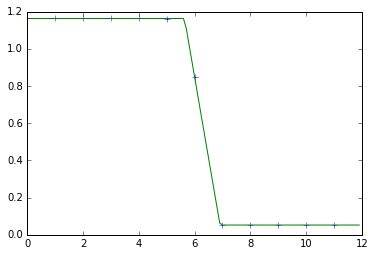

In [24]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

# Keep only the frames for which the excitation is on and save

In [25]:
D4=np.transpose(data[:,:,:,range(ONint,(OFFint+1))],(2,1,0,3))
nim=nib.Nifti1Image(D4,np.eye(4))
nib.save(nim,'/home/sophie/Desktop/'+Dataname+'on.nii.gz')

# Get times corresponding to images (exctiation light completely on : t=0)

In [35]:
TimeFile='/home/sophie/Downloads/Data'+''.join([Dataname[i] for i in range(3)])+'_.csv'

In [36]:
print(TimeFile)

/home/sophie/Downloads/Data945_.csv


In [37]:
Listfile = open(TimeFile, 'r')
ListTime = [line.split('\n')[0] for line in Listfile.readlines()]

In [38]:
Timespl=[float(ListTime[i].split(',')[2]) for i in range(1,len(ListTime))]

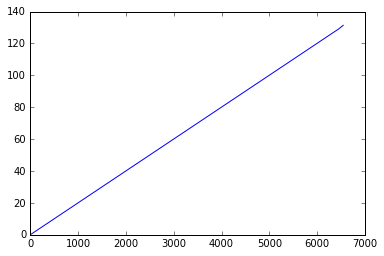

In [39]:
plt.plot(Timespl)

In [40]:
max(Timespl)

131.394043

In [41]:
TimeOn=[Timespl[i] for i in range(ONint,(OFFint+1))]

In [42]:
Tinit=(ON-ONint-1)*(Timespl[ONint]-Timespl[ONint-1])+Timespl[ONint-1]

In [43]:
TimeOnFinal=TimeOn-Tinit

In [44]:
D4.shape

(208, 208, 40, 5900)

In [45]:
sio.savemat('/home/sophie/Desktop/'+Dataname+'TimeFluoOn.mat', {'TimeFluoOn':TimeOnFinal})